# Object counting using 2-connected components - bloodcells#


This notebook presents comparison between effects of application of two algorithms for node connectivity: biconnected_components and approximative version of k_components and also two for edge connectivity: k_edge_components, k_edge_subgraphs. The second one gives us better results. After rejecting small components both methods gives similar results.

## Table of contents:
##### 1. Import of modules
##### 2. Transformation an image into a graph
##### 3. Visualization of the effects of segmentation
##### 4. Preparing image
##### 5. Blood cells counting - functions
##### 6. Summary
##### 7. Blood cells counting - all results
###### a) Node connectivity
###### b) Edge connectivity

## 1. Import of modules##

In [1]:
from PIL import Image
from skimage import io, filters,measure
import cv2
import numpy as np
import networkx as nx
from graphviz import Graph
from networkx.algorithms import approximation as apxa
from random import randint,random
import matplotlib.pyplot as plt
import glob, os
from datetime import timedelta
import time

## 2. Transformation an image into a graph ##

In [2]:
def define_nodes(graph, shape):
    for i in range(shape[0]):
        for j in range(shape[1]):
            graph.add_node((i, j)) 

In [3]:
def define_edges(graph, channel, shape, degree):
    if degree==4:
        for i in range(shape[0]):
            for j in range(shape[1]):
                if i - 1 >= 0 and channel[i][j] == channel[i-1][j]:
                    graph.add_edge((i, j), (i-1, j), weight=channel[i][j])
                if j - 1 >= 0 and channel[i][j] == channel[i][j-1]:
                    graph.add_edge((i, j), (i, j-1), weight=channel[i][j])
    if degree==8:
        for i in range(shape[0]):
            for j in range(shape[1]):
                if i - 1 >= 0 and channel[i][j] == channel[i-1][j]:
                    graph.add_edge((i, j), (i-1, j), weight=channel[i][j])
                if j - 1 >= 0 and channel[i][j] == channel[i][j-1]:
                    graph.add_edge((i, j), (i, j-1), weight=channel[i][j])
                if i - 1 >= 0 and j - 1 >= 0 and channel[i][j]==channel[i-1][j-1]:
                    graph.add_edge((i, j), (i-1, j-1), weight=channel[i][j])
                if i - 1 >= 0 and j + 1 < shape[0] and channel[i][j] == channel[i-1][j+1]:
                    graph.add_edge((i, j), (i-1, j+1), weight=channel[i][j])

## 3. Visualization of the effects of segmentation  ##

In [4]:
def reject_small_comp(big_set,l):
    big_set.remove(max(big_set, key=len))
    reject_set=[]
    for comp in big_set:
        if len(comp)<=l:
            reject_set.append(comp)
    normal_comp = [item for item in big_set if item not in reject_set]
    return normal_comp

In [5]:
def median(bicomponents):
    volume=[]
    for comp in bicomponents:
        volume.append(len(comp))
    return np.quantile(volume,0.5,axis=0)

In [6]:
def get_result_channel_random(channel, two_connected_components):

    result = np.full(channel.shape, 255)

    random_color = lambda: int(random()*255)
    colors = [random_color() for i in range(len(two_connected_components))]
    i=0
    for component in two_connected_components:
        for pair in component:
            result[pair[0]][pair[1]] = colors[i]
        i+=1   
    result = np.array(result, dtype='int16')
    return result

## 4. Preparing image

In [7]:
def converting_to_binary(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        cv2.drawContours(thresh,[cnt],0,255,-1)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel,iterations=2)
    return opening

In [8]:
def scaling_image(image,shape):
    if(shape[1]>700 or shape[0]>700):
        scale_percent = 70 
        width = int(shape[1] * scale_percent / 100)
        height = int(shape[0] * scale_percent / 100)
        new_shape= (width, height)    
        image = image.resize(new_shape)    
    return image

## 5. Blood cells counting 

#### Maximum degree equals 4 or 8:

In [9]:
def two_connected_components_binary(image, version, function, degree):
    start_time = time.monotonic()
    f=plt.figure(figsize=(11,9))
    f1=f.add_subplot(2,2,1)
    f1=plt.imshow(image)
    
    image_1=converting_to_binary(image)
    image = Image.fromarray(image_1)
    
    f2=f.add_subplot(2,2,2)
    f2=plt.imshow(image)
    
    image=scaling_image(image,image_1.shape)
   
    image_arr = np.array(image, dtype='int16')
    
    graph = nx.Graph()
    define_nodes(graph, image_arr.shape)
    define_edges(graph, image_arr, image_arr.shape,degree)
    
    if version=="node":
        if function=="biconnected_components":
            comps = nx.biconnected_components(graph)
            comps = list(comps)
        if function=="k_components":
            comps = apxa.k_components(graph)
            comps = comps[2]   
    if version=="edge":
        if function=="k_edge_components":
            comps = nx.k_edge_components(graph,2)
            comps = list(comps)
        if function=="k_edge_subgraphs":
            comps = nx.k_edge_subgraphs(graph,2)
            comps = list(comps)       
    
    result1 = get_result_channel_random(image_arr,comps)    
    f3=f.add_subplot(2,2,3)
    f3=plt.title("Before: "+str(len(comps)-1))
    f3=plt.imshow(result1) 
    
    p=median(comps)

    comps_smaller=reject_small_comp(comps,int(p/2))
    
    result2 = get_result_channel_random(image_arr, comps_smaller)
    f4=f.add_subplot(2,2,4)
    f4=plt.title("After: "+str(len(comps_smaller)))
    f4=plt.imshow(result2)
    end_time = time.monotonic()
    print("Time="+str(timedelta(seconds = end_time - start_time)))
    plt.show()   

##### Version:
##### 1) "node":
###### function: 
###### "bi" - biconnected_components(graph)
###### "two" - k_components(graph)[2]
##### 2) "edge":
###### function: 
###### "component" - k_edge_components(graph,2)
###### "subgraph" - k_edge_subgraphs(graph,2)
##### Degree:
###### almost 4-regular or almost 8-regular

## 6. Summary

Results below came from independent tests so can differ from segmentation effects (point 7).

| Image | Maximum degree | Version (node/edge) | Function (from networkx) | k connectivity | 1. time (minutes:seconds) | 2. time (minutes:seconds) | 3. time (minutes:seconds) | Number of components |
| - | - | - | - | - | - | - |-| -|
| 1 | 4 | node | biconnected_components | 2 | 10.484 | - | - | 148 |
| 1 | 4 | node | k_components (approx.) | 2 | 17.172 | - | - | 148 |
| 1 | 4 | edge | k_edge_components | 2 | 30.891 | - | - | 148 |
| 1 | 4 | edge | k_edge_subgraphs | 2 | 37.484 | - | -  |148 |
| 1 | 8 | node | biconnected_components | 2 | 16.828 | - | - |148 |
| 1 | 8 | node | k_components (approx.)  | 2 | 10 h + | - | - | - |
| 1 | 8 | edge | k_edge_components | 2 | 01:12.563 | 43.438 | 49.641 | 148 |
| 1 | 8 | edge | k_edge_subgraphs | 2 | 01:10.859 | 46.188 | 46.265 | 148 |
| 2 | 4 | node | biconnected_components | 2 | 07.343  | - | - | 166 |
| 2 | 4 | node | k_components (approx.)  | 2 | 11.266 | - | -  |164 |
| 2 | 4 | edge | k_edge_components | 2 | 16.579  | - | - | 165 |
| 2 | 4 | edge | k_edge_subgraphs | 2 | 15.734 | - | - | 165 |
| 2 | 8 | node | biconnected_components | 2 | 07.796 |  - | - |162 |
| 2 | 8 | node | k_components (approx.)  | 2 | - | - | - | - |
| 2 | 8 | edge | k_edge_components | 2 | 23.907 | - | - | 162 |
| 2 | 8 | edge | k_edge_subgraphs | 2 | 21.922 | - | - | 162 |

## 7. Blood cells counting - all results

### Maximum degree = 4:

### a) Node connectivity

#### Image 1

In [13]:
img1 = cv2.imread('blood_cells.jpg')

##### 1. method - biconnected_components

Time=0:00:16.359000


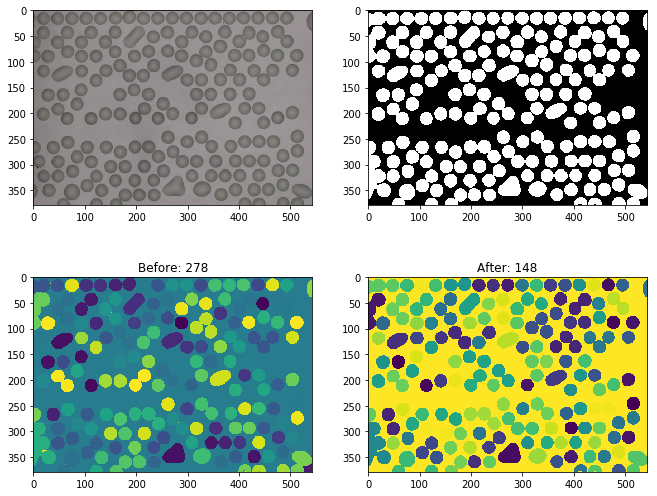

In [12]:
two_connected_components_binary(img1,"node","biconnected_components",4)

##### 2. method - k_components[2]

Time=0:00:14.890000


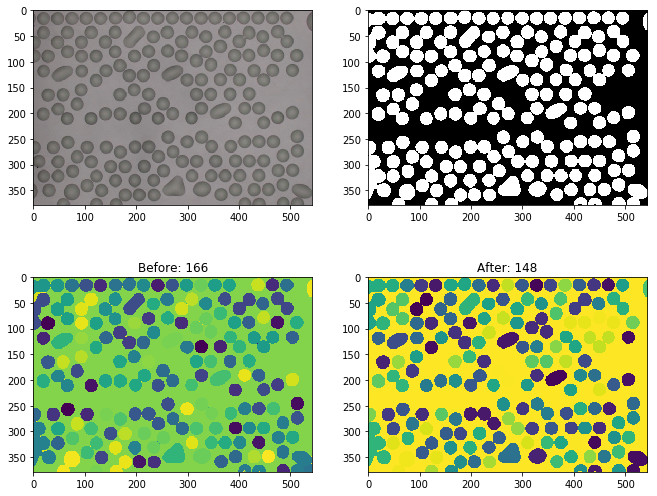

In [13]:
two_connected_components_binary(img1,"node","k_components",4)

#### Image 2

In [14]:
img2 = cv2.imread('red_blood_cells.png')

##### 1. method - biconnected_components

Time=0:00:10.594000


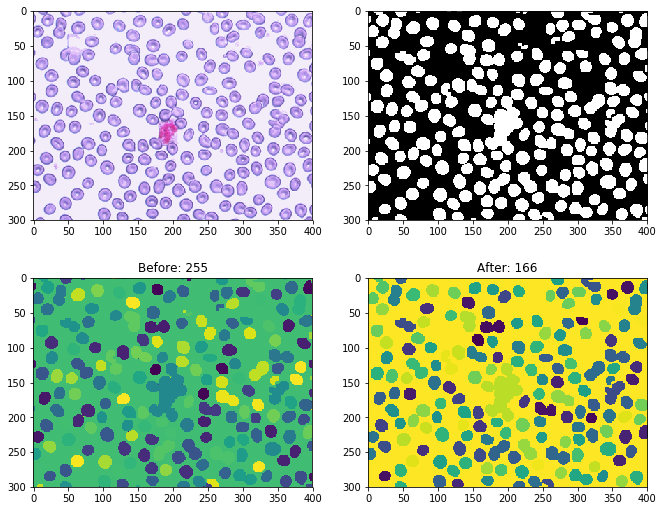

In [15]:
two_connected_components_binary(img2,"node","biconnected_components",4)

##### 2. method- k_components[2]

Time=0:00:15


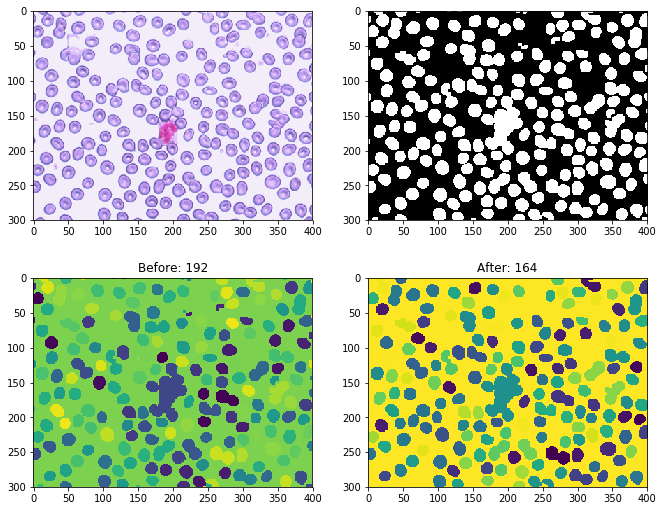

In [16]:
two_connected_components_binary(img2,"node","k_components",4)

### b) Edge connectivity

#### Image 1

##### 1. method - k_edge_components(graph,2)

Time=0:00:22.687000


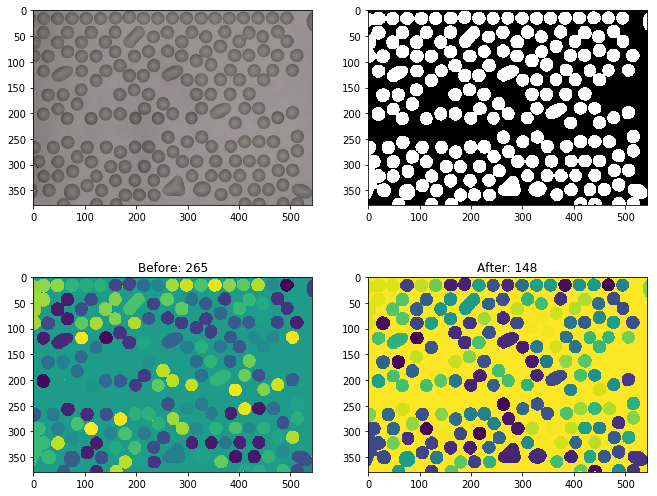

In [17]:
two_connected_components_binary(img1,"edge","k_edge_components",4)

##### 2. method - k_edge_subgraphs(graph,2)

Time=0:00:25.203000


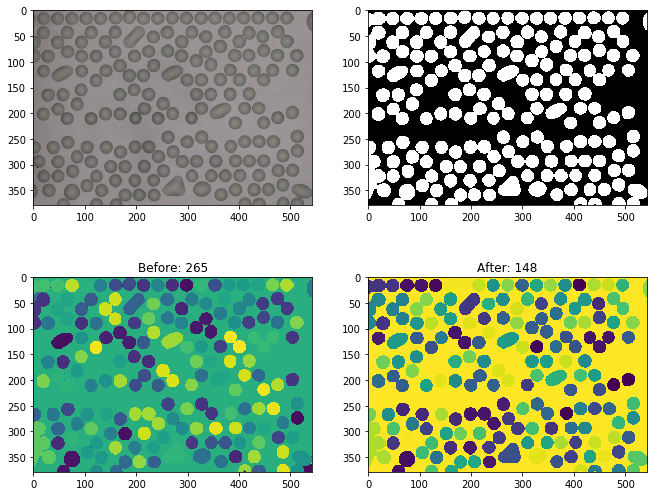

In [18]:
two_connected_components_binary(img1,"edge","k_edge_subgraphs",4)

#### Image 2

##### 1. method - k_edge_components(graph,2)

Time=0:00:15.641000


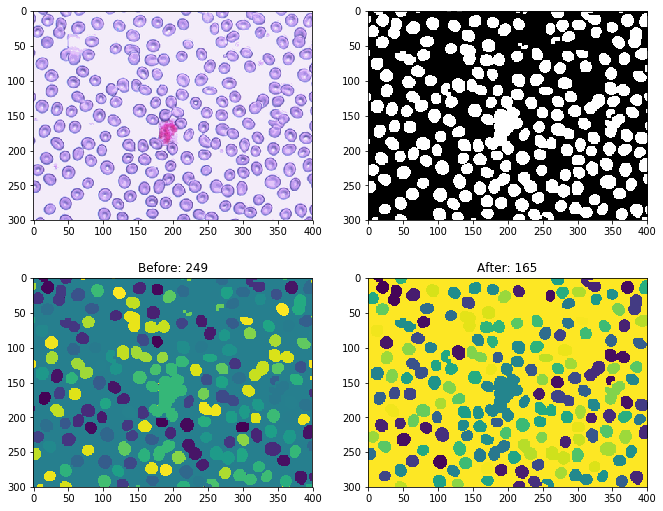

In [19]:
two_connected_components_binary(img2,"edge","k_edge_components",4)

##### 2. method - k_edge_subgraphs(graph,2)

Time=0:00:21.219000


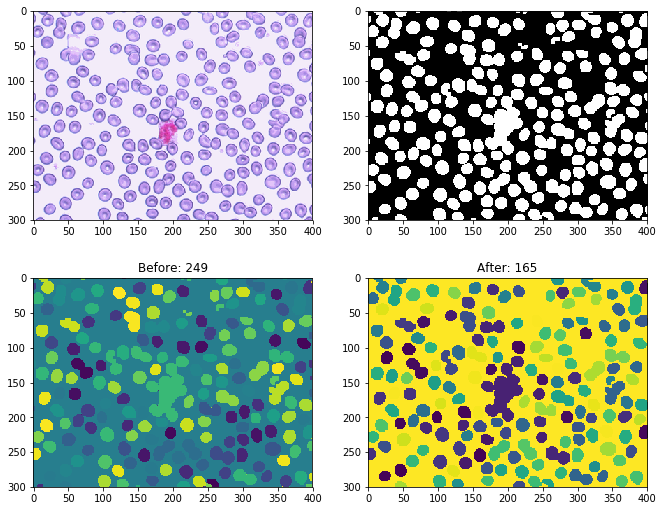

In [20]:
two_connected_components_binary(img2,"edge","k_edge_subgraphs",4)

### Maximum degree = 8:

### a) Node connectivity

#### Image 1

##### 1. method - biconnected_components

Time=0:00:25.250000


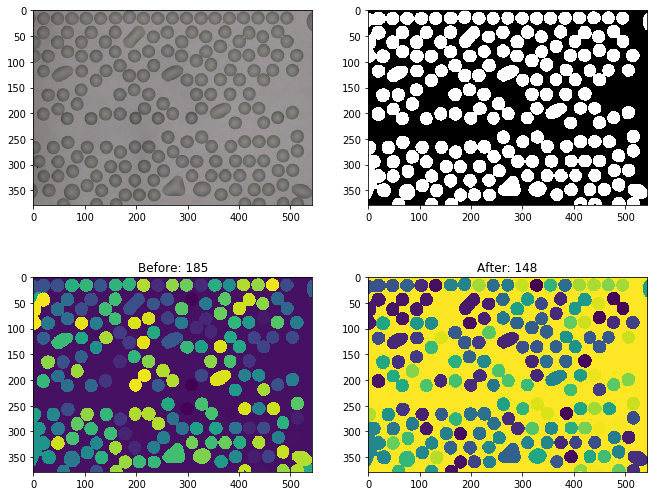

In [21]:
two_connected_components_binary(img1,"node","biconnected_components",8)

#### Image 2

##### 1. method - biconnected_components

Time=0:00:16.188000


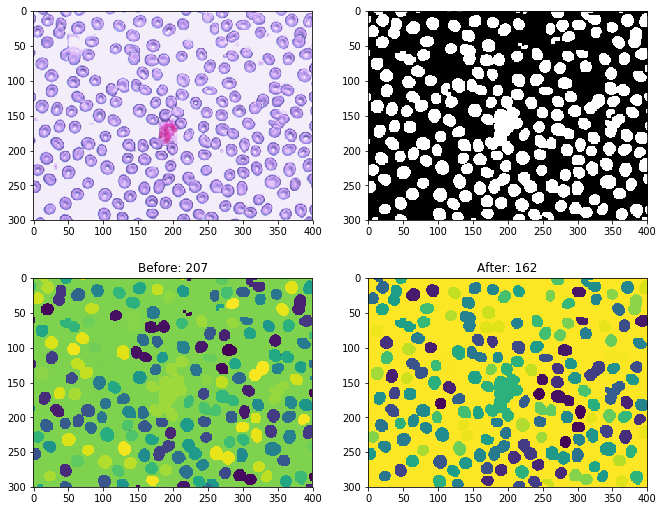

In [16]:
two_connected_components_binary(img2,"node","biconnected_components",8)

### b) Edge connectivity

#### Image 1

##### 1. method - k_edge_components(graph,2)

Time=0:01:10.750000


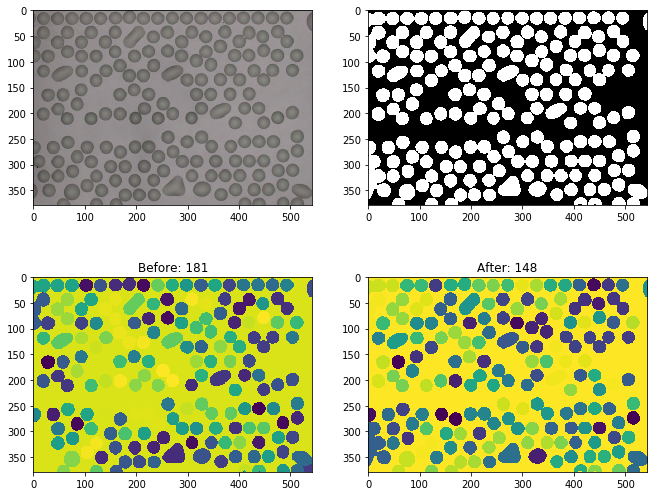

In [15]:
two_connected_components_binary(img1,"edge","k_edge_components",8)

##### 2. method - k_edge_subgraphs(graph,2)

Time=0:01:11.812000


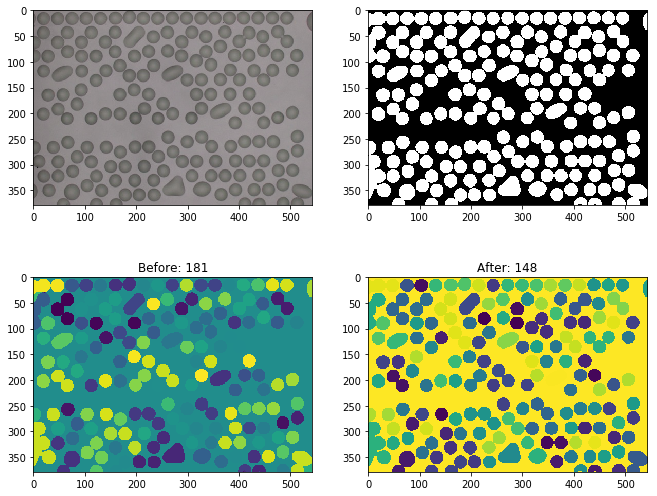

In [17]:
two_connected_components_binary(img1,"edge","k_edge_subgraphs",8)

#### Image 2

##### 1. method - k_edge_components(graph,2)

Time=0:00:42.406000


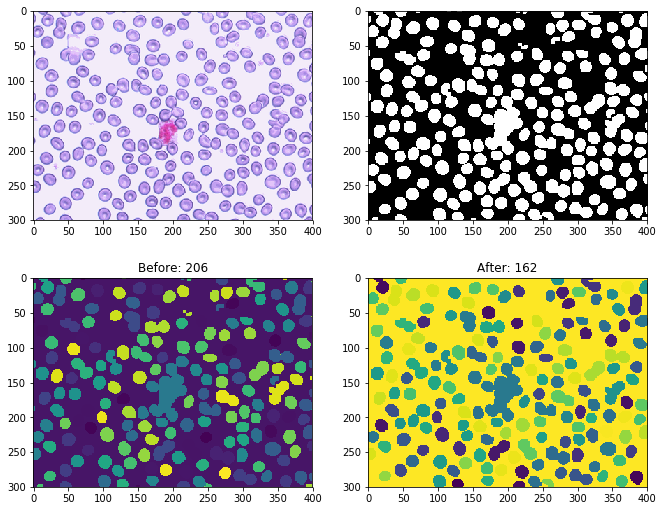

In [18]:
two_connected_components_binary(img2,"edge","k_edge_components",8)

##### 2. method - k_edge_subgraphs(graph,2)

Time=0:00:41.547000


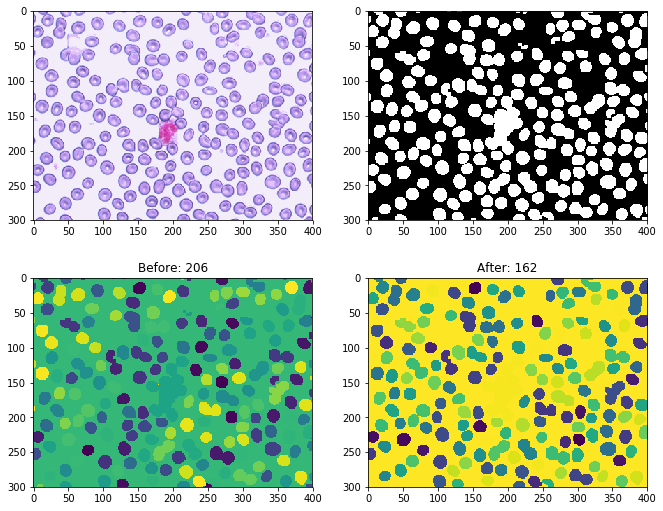

In [19]:
two_connected_components_binary(img2,"edge","k_edge_subgraphs",8)